# Questions
- What are git remotes, how do they work, how do they edit them, how do I fix mine
- How do I push to my main branch of git
- Follow up on CAPS question on tokenization section

# Extract raw data
### Expected Format: 
<font color='red'>[</font>{<font color='green'>'text':</font> 'All services should have a dedicated channel for reporting fraud. We see and hear about a lot of fraud on small platforms, especially dating sights and job boards. ',
  <font color='green'>'label':</font> 0,
  <font color='green'>'summary':</font> 'Every service should have a dedicated reporting channel for fraud, because there is lots of fraud on a range of platforms. '}, <font color='red'>...]</font>

In [1]:
# MS: create training set, evaluation set and validation set
import sys
import pandas as pd
import csv

dataset_name = "/home/azureuser/cloudfiles/code/Users/Omololu.Makinde/Llama_tutorial/data/consultation2.csv"
dataset = []

with open(dataset_name, encoding='utf-8-sig') as FID:
    csvReader = csv.DictReader(FID, delimiter="\t")
    for key, row in enumerate(csvReader): 
        # print(key, row)
        dataset.append({
            "label" : row['Topic'].strip().lower().replace('\n', ''),
            "text" : row['Full summary of comment'],
            "summary" : row['One-line summary']
        })

df_dataset = pd.DataFrame(dataset)
df_dataset.drop(columns =['summary'], inplace=True)  # don't need this for now
display(df_dataset)

,label,text
0,user reporting and complaints (u2u and search),All services should have a dedicated channel f...
1,governance and accountability,"This mitigation should apply to all services, ..."
2,governance and accountability,Evidence of new kinds of illegal content on a ...
3,governance and accountability,A Code of Conduct or principles provided to al...
4,governance and accountability,"Staff, in particular engineers, involved in th..."
...,...,...
1890,governance and accountability,Snap asked that Ofcom consider how this measur...
1891,ror,Supports Ofcoms wide use of litrature to regog...
1892,approach to codes,They support the use of the STIM but alongside...
1893,icjg,ASW should be expected to take more of a proac...


# Data Check

In [2]:
df_dataset_count = df_dataset['label'].value_counts()
df_dataset['label'].value_counts()

label
approach to the codes                                                               468
automated content moderation (user to user)                                         270
governance and accountability                                                       228
user reporting and complaints (u2u and search)                                      140
content moderation (user to user)                                                   128
user access to services (u2u)                                                       111
enhanced user control (u2u)                                                         101
default settings and user support (u2u)                                              89
cumulative assessment                                                                76
terms of service and publicly available statements                                   60
recommender system testing (u2u)                                                     59
content moderation (search

In [3]:
keep_rows = list(df_dataset_count[df_dataset_count > 10].index)
df_dataset = df_dataset[df_dataset['label'].isin(keep_rows)]
display(df_dataset['label'].value_counts())

label
approach to the codes                                 468
automated content moderation (user to user)           270
governance and accountability                         228
user reporting and complaints (u2u and search)        140
content moderation (user to user)                     128
user access to services (u2u)                         111
enhanced user control (u2u)                           101
default settings and user support (u2u)                89
cumulative assessment                                  76
terms of service and publicly available statements     60
recommender system testing (u2u)                       59
content moderation (search)                            52
service design and user support (search)               30
automated content moderation (search)                  25
statutory tests                                        22
Name: count, dtype: int64

# Convert labels to binary classifier format
- 'governance and accountability' = 1, everything else = 0

Note data set heavily imbalanced so accuracy would be a poor metric of evaluating our model (in its current state)

In [4]:
import numpy as np

# add in our classifier labels
topic = 'governance and accountability'
df_dataset['label'] = np.where(np.array(df_dataset['label']) == topic, 1, 0)
df_dataset['label'].value_counts(normalize=False)

label
0    1631
1     228
Name: count, dtype: int64

# Extract Evaluation Set

In [5]:
# train and test data
class_len = len(df_dataset[df_dataset['label'] == 1])  # find how many values we can take and still have a balanced class
class_0_data = df_dataset[df_dataset.label.eq(0)].sample(class_len) 
class_1_data = df_dataset[df_dataset.label.eq(1)].sample(class_len)
train_test_data = pd.concat([class_0_data, class_1_data])  # 50/50 class split
display(train_test_data)

# evaluation data
eval_data = df_dataset.drop(train_test_data.index)  # put the rest into an evaluation set we can play with
eval_data

,label,text
792,0,Match Group agrees with Ofcom’s proposal that ...
88,0,Response: We agree with Ofcom that given the d...
1151,0,If Ofcom is unwilling to apply a blanket thres...
341,0,Satisfied with the proposal for the most onero...
96,0,We encourage close coordination between the EU...
...,...,...
340,1,"We believe that organisations, in addition to ..."
1234,1,Ofcoms proposals are proportionate
460,1,Services are required to track new and increas...
894,1,The suggestion is that the proposal risks forc...


,label,text
0,0,All services should have a dedicated channel f...
7,0,"When prioritising what content to review, rega..."
8,0,"(Disagree). As noted before, ""there should be ..."
12,0,The RSPCA agrees that the most onerous measure...
13,0,The RSPCA agrees that the most onerous measure...
...,...,...
1880,0,We apply account blocks based on signals inclu...
1881,0,It is Snap’s practice to generally apply accou...
1883,0,"We would stress that this issue is not easily,..."
1884,0,Notwithstanding an appeal being successful and...


# Transform data to usable version for huggingface model

### Using distilbert base uncased model
- BERT = is an LLM (large language model)
- distil = smaller model with most of the same power as a normal bert model
- base = not much tweaking or tuning done yet
- uncased = captilised letters make no difference i.e. england = EnglaND (Note: probably want to still consider this in case we change to an cased model)

### Tokenizing our data using our base model
- Tokenizing is breaking our data up into smaller parts for our model to read (note that tokens are always just words but can be special chars or subwords)
- Embedding (not used for this model) take individual token and turning it into a more computer friendly format through transforming it into a hidden multi-dimensional-numeric format e.g. cat -> (12, 45))
- Work from huggingface dataset 
- Only want to tokenize our text
- Pad using special characters (adds length up to the min tensor value) the values if necessary
- Truncate (shortens to the max tensor value) the values if necessary (up to max length)

In [6]:
from datasets import Dataset
from transformers import AutoTokenizer

huggingface_data = Dataset.from_pandas(train_test_data, preserve_index=False)  # don't include pandas index

pretrained_model_name = "distilbert/distilbert-base-uncased"  # This is our base model

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
def proc_data(data):
    return tokenizer(data['text'], max_length=512, padding=True, truncation=True)

tokenized_data = huggingface_data.map(proc_data, batched=True)  # advantage of ".map" is we can parallel process data in batches (i think)
# print(tokenized_data['text'] == huggingface_data['text'])  # SHOULDN'T THIS NOT BE TRUE??? ESPECIALLY IF I CHANGE MAX_LENGTH TO BE 1 OR SOMETHING

split_tokenized_hugginface_data = tokenized_data.train_test_split(test_size=0.10)  # 85/15 train/test split
print(split_tokenized_hugginface_data)

/anaconda/envs/llm_parser/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 410
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 46
    })
})


# Train model
- 1 = "Positive" -> the model is predicting that the input CAN be caterogirsed by our input topic
- 0 = "Negative" -> the model is predicting that the input can NOT be caterogirsed by our input topic

Instead of doing evaluate.load(metric), can load several metrics using accuracy.combine([metric1, metric2, ...])

Note:
- Just reducing test set size from 15% to 10% had about 10% improvement on accuracy
- Use <font color='green'>".select(range(X))"</font> in place of <font color='green'>"[:X]"</font>. Measurable increase in accuracy from just 50 more sample but still decent accuracy and improvements without much training data

In [7]:
import os
import shutil

def clear_folder_except(folder_path, exclude_folder):
    # Iterate over the items in the directory
    for item_name in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item_name)
        # Skip the exclude folder
        if item_name == exclude_folder:
            continue
        # Check if the item is a directory
        if os.path.isdir(item_path):
            # If it is a directory, remove it and its contents
            shutil.rmtree(item_path)
        else:
            # If it is a file, remove it
            os.remove(item_path)

In [96]:
# -HOT FIX TO STOP MODEL TRAINING BREAKING----------------------------------------------------------------------------------------------------------- #
model_output_path = "/home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_1"
# clear_folder_except(model_output_path, "runs")
# --------------------------------------------------------------------------------------------------------------------------------------------------- #


from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import evaluate


# Select accuracy metric
evaluation_metrics = ["accuracy", "f1", "precision", "recall"]
accuracy = evaluate.combine(evaluation_metrics)# evaluate.load("accuracy")

# Use accuracy to determine which class is the most likely prediction
def compute_metrics(eval_pred):
    predictions, labels = eval_pred  # get predictions and labels
    predictions = np.argmax(predictions, axis=1)  # calculate highest probability class (negative or positive sentiment)
    return accuracy.compute(predictions=predictions, references=labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative": 0, "Positive": 1}


model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name,
                                                            id2label=id2label,
                                                            label2id=label2id)

# How we input training arguments into the model

training_args = TrainingArguments(
    output_dir=model_output_path,  # path model stored
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    # logging_steps= 25 # logs made every X batches. So smaller log means more information recorded (see log in table but also more computational and memory requirements)
    )


# Model training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_tokenized_hugginface_data["train"],#.select(range(200)),
    eval_dataset=split_tokenized_hugginface_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Stop training if no improvement after 3 consecutive epochs

)

# Train model
results = trainer.train()

trainer.save_model("/home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_1/Best")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/llm_parser/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.556641,0.739130,0.785714,0.758621,0.814815
2,No log,0.473339,0.782609,0.807692,0.840000,0.777778
3,No log,0.476721,0.804348,0.836364,0.821429,0.851852
4,No log,0.587035,0.782609,0.814815,0.814815,0.814815
5,No log,0.683818,0.804348,0.830189,0.846154,0.814815
6,No log,0.758435,0.782609,0.821429,0.793103,0.851852
7,No log,0.769559,0.826087,0.851852,0.851852,0.851852
8,No log,0.860448,0.826087,0.846154,0.880000,0.814815
9,No log,0.911120,0.760870,0.807018,0.766667,0.851852
10,No log,0.945182,0.760870,0.807018,0.766667,0.851852


Checkpoint destination directory /home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_1/checkpoint-26 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_1/checkpoint-52 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_1/checkpoint-78 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_1/checkpoint-104 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/azur

In [100]:
print(dir(results))
print(results.training_loss)
print(results)

['__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__orig_bases__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'global_step', 'index', 'metrics', 'training_loss']
0.10541266168539341
TrainOutput(global_step=520, training_loss=0.10541266168539341, metrics={'train_runtime': 258.9343, 'train_samples_per_second': 31.668, 'train_steps_per_second': 2.008, 'total_flos': 1086232668979200.0, 'train_loss': 0.10541266168539341, 'epoch': 20.0})


In [94]:
from evaluate import evaluator
task_evaluator = evaluator("text-classification")
task_evaluator.compute(model="/home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_approach to the codes")

ValueError: Please specify a valid `data` object - either a `str` with a name or a `Dataset` object.

In [16]:
test_data = Dataset.from_pandas(eval_data, preserve_index=False)  # don't include pandas index
test_data = test_data.map(proc_data, batched=True) 

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1403/1403 [00:00<00:00, 4293.91 examples/s]


In [ ]:
eval_data

In [47]:
predictions, labels, metrics = trainer.predict(test_data)
print(predictions)

/anaconda/envs/llm_parser/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[-0.13651986  0.18529259]
 [ 0.8230903  -0.7720542 ]
 [-0.13704707  0.2995234 ]
 ...
 [ 1.2004975  -1.0411704 ]
 [ 1.0460117  -0.8857551 ]
 [ 1.0958154  -0.98287666]]


In [50]:
import numpy as np

def softmax(logits):
    exp_scores = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

probabilities = softmax(predictions)
logits = predictions

In [54]:
# Predicted classes based on logits (note how we get the same result)
predicted_classes_prob = np.argmax(probabilities, axis=1)
predicted_classes_log = np.argmax(logits, axis=1)

print(sum(predicted_classes_log))

386


In [10]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import evaluate
model_output_path = "/home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_1"


training_args = TrainingArguments(
    output_dir=model_output_path,  # path model stored
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False

    # logging_steps= 25 # logs made every X batches. So smaller log means more information recorded (see log in table but also more computational and memory requirements)
    )

print(dir(training_args))
print(training_args.output_dir)

['__annotations__', '__cached__setup_devices', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_n_gpu', '_no_sync_in_gradient_accumulation', '_setup_devices', 'accelerator_config', 'adafactor', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'auto_find_batch_size', 'bf16', 'bf16_full_eval', 'data_seed', 'dataloader_drop_last', 'dataloader_num_workers', 'dataloader_persistent_workers', 'dataloader_pin_memory', 'dataloader_prefetch_factor', 'ddp_backend', 'ddp_broadcast_buffers', 'ddp_bucket_cap_mb', 'ddp_find_unused_parameters', 'ddp_timeout', 'ddp_timeout_delta', 'debug', 'deepspeed', 'deepspeed_plugi

[1 0 1 ... 0 0 0] [0 0 0 ... 0 0 0] (1403,) (1403,)


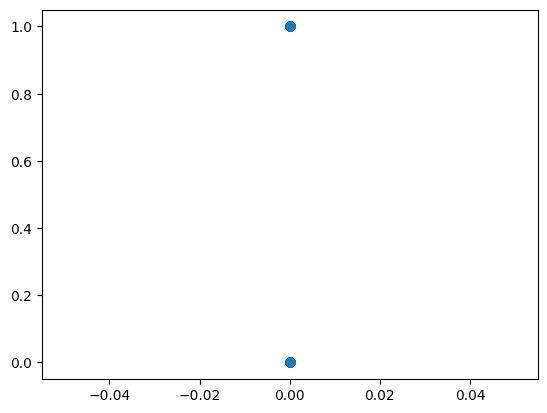

In [88]:
from matplotlib import pyplot as plt
print(predicted_classes_prob, labels, labels.shape, predicted_classes_prob.shape)
plt.scatter(labels, predicted_classes_prob)

In [86]:
cfm_metric = evaluate.load("BucketHeadP65/confusion_matrix")
results = cfm_metric.compute(references=labels, predictions=predicted_classes_prob, normalize="all")
results


{'confusion_matrix': array([[0.72487527, 0.27512473],
        [0.        , 0.        ]])}

In [29]:
import numpy as np
list(np.arange(10**-4, 0.1, 0.001))

[0.0001,
 0.0011,
 0.0021,
 0.0031,
 0.0041,
 0.0051,
 0.0061,
 0.0071,
 0.0081,
 0.0091,
 0.0101,
 0.011099999999999999,
 0.0121,
 0.0131,
 0.0141,
 0.015099999999999999,
 0.0161,
 0.0171,
 0.0181,
 0.0191,
 0.0201,
 0.0211,
 0.022099999999999998,
 0.0231,
 0.0241,
 0.0251,
 0.0261,
 0.0271,
 0.0281,
 0.0291,
 0.0301,
 0.0311,
 0.032100000000000004,
 0.033100000000000004,
 0.034100000000000005,
 0.035100000000000006,
 0.03610000000000001,
 0.0371,
 0.0381,
 0.0391,
 0.040100000000000004,
 0.041100000000000005,
 0.042100000000000005,
 0.043100000000000006,
 0.0441,
 0.0451,
 0.0461,
 0.0471,
 0.048100000000000004,
 0.049100000000000005,
 0.050100000000000006,
 0.051100000000000007,
 0.05210000000000001,
 0.0531,
 0.0541,
 0.0551,
 0.056100000000000004,
 0.057100000000000005,
 0.058100000000000006,
 0.05910000000000001,
 0.0601,
 0.0611,
 0.0621,
 0.0631,
 0.0641,
 0.0651,
 0.0661,
 0.0671,
 0.06810000000000001,
 0.06910000000000001,
 0.07010000000000001,
 0.07110000000000001,
 0.072100

In [87]:
print(dir(cfm_metric))

['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_data_dir', '_check_all_processes_locks', '_check_rendez_vous', '_compute', '_create_cache_file', '_data_dir_root', '_download_and_prepare', '_enforce_nested_string_type', '_feature_names', '_finalize', '_get_all_cache_files', '_hash', '_infer_feature_from_batch', '_infer_feature_from_example', '_info', '_init_writer', '_module_info', 'add', 'add_batch', 'buf_writer', 'cache_file_name', 'citation', 'codebase_urls', 'compute', 'config_name', 'data', 'data_dir', 'description', 'download_and_prepare', 'experiment_id', 'features', 'file_paths', 'filelock', 'filelocks', 'format', 'homepage', 'info', 'inputs_

In [42]:
print(predictions.metrics)
print(dir(predictions))

{'test_loss': 0.5473019480705261, 'test_accuracy': 0.7248752672843906, 'test_f1': 0.0, 'test_precision': 0.0, 'test_recall': 0.0, 'test_runtime': 7.8116, 'test_samples_per_second': 179.604, 'test_steps_per_second': 11.265}
['__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__orig_bases__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'index', 'label_ids', 'metrics', 'predictions']


# Inferencer

In [10]:
from tika import parser
pdf_filepath = "/home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Overview.pdf"
parsed_file = parser.from_file(pdf_filepath)['content']
print(parsed_file)

FileNotFoundError: [Errno 2] No such file or directory: '/home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Overview.pdf'

In [ ]:
import time
s = time.time()

In [ ]:
time.time()-s

0.01980757713317871

# Split inference document
- This embedding is better than the one we used for bert
- Couldn't use this for bert tokenisation/embeddings because we needed a bert tokenizer since our model is BERT

Now we have our document in a machine readable form we need to split the doc into parts we can apply the model on and tag. We could do this using delimeters like paragraphs but a semanic splitter will hopefully seperate the doc by content i.e. each now input should be a new tag

Q: Do we not need to clean the chunks?

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding = HuggingFaceEmbeddings(model_name="avsolatorio/GIST-small-Embedding-v0")  # get embeddings model
text_splitter = SemanticChunker(embedding)  # apply the model to the type of split we want to perform (a semantic split)
chunks = text_splitter.create_documents([parsed_file])

# Store spliced pdf in json file

In [ ]:
outfile = "/home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Output_Data/Inf_res.json"
# print(len(chunks), chunks[0])

import json
# from collections import defaultdict

# # If the output file doesn't exist then create one
# if not os.path.isfile(outfile):
#     dict_chunks = defaultdict(list)
#     for par in chunks:
#         dict_chunks[par.page_content]=[]
#     with open(outfile, "w") as outfile: 
#         json.dump(dict_chunks, outfile, indent = 4)
#     print(outfile)

In [ ]:
chunks

[Document(page_content='\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n \n\n \n\n \n \n\nOverview \nThis document is the first of four major consulta�ons that Ofcom, as appointed regulator of the \nnew Online Safety Act (‘the Act’), will publish as part of our work to establish the new regula�ons \nover the next 18 months. It focuses on our proposals for how internet services which enable the sharing of user generated \ncontent (‘user-to-user’ or ‘U2U’ services) and search services should approach their new du�es \nrela�ng to illegal content. It covers the following areas: the causes and impacts of illegal harms; how \nservices should assess and mi�gate the risks of illegal harms; how services can iden�fy illegal \ncontent; and our approach to enforcement. The proposals in this document reflect research we have conducted over the past three years as well \nas informa�on and evidence gathered through extensive engagement with industry and other

# Open file back into data

In [ ]:
# with open(str(outfile), 'r') as empt_par:
#     strored_chunk = json.load(empt_par)
# strored_chunk

{'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n \n\n \n\n \n \n\nOverview \nThis document is the first of four major consulta�ons that Ofcom, as appointed regulator of the \nnew Online Safety Act (‘the Act’), will publish as part of our work to establish the new regula�ons \nover the next 18 months. It focuses on our proposals for how internet services which enable the sharing of user generated \ncontent (‘user-to-user’ or ‘U2U’ services) and search services should approach their new du�es \nrela�ng to illegal content. It covers the following areas: the causes and impacts of illegal harms; how \nservices should assess and mi�gate the risks of illegal harms; how services can iden�fy illegal \ncontent; and our approach to enforcement. The proposals in this document reflect research we have conducted over the past three years as well \nas informa�on and evidence gathered through extensive engagement with industry and other \nexperts. Causes and

# Use inferencing pipeline to tag data with model prediction

- Can use our pipeline to determine a tag with pipeline(input_text) and it will output the label and score

Q: Why don't we use a real_data pdf for the inferencing?

In [ ]:
from transformers import pipeline

def inference_pipeline(model_path, max_length=512):
   pipe = pipeline("text-classification", model=model_path, max_length=max_length, truncation=True)
   return pipe

best_model_path = "/home/azureuser/cloudfiles/code/Users/Michael.Sowter/Deep_Learning_Training/Text Classifier/Models/Mod_1/Best"
infer = inference_pipeline(best_model_path)


2024-05-15 13:22:45.800572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 13:22:47.389439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# test
print(infer("Governance"))
print(infer("Bye"))

[{'label': 'Negative', 'score': 0.8220359683036804}]
[{'label': 'Negative', 'score': 0.716924786567688}]


In [ ]:
chunks[0].page_content

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n \n\n \n\n \n \n\nOverview \nThis document is the first of four major consulta�ons that Ofcom, as appointed regulator of the \nnew Online Safety Act (‘the Act’), will publish as part of our work to establish the new regula�ons \nover the next 18 months. It focuses on our proposals for how internet services which enable the sharing of user generated \ncontent (‘user-to-user’ or ‘U2U’ services) and search services should approach their new du�es \nrela�ng to illegal content. It covers the following areas: the causes and impacts of illegal harms; how \nservices should assess and mi�gate the risks of illegal harms; how services can iden�fy illegal \ncontent; and our approach to enforcement. The proposals in this document reflect research we have conducted over the past three years as well \nas informa�on and evidence gathered through extensive engagement with industry and other \nexperts. Causes and 

In [ ]:
# try on our data
infer(str(chunks)[0].replace("\n\n", ""))

[{'label': 'Negative', 'score': 0.5996244549751282}]

In [ ]:
# Now do it properly
res = {}

for chunk in chunks:
    i = chunk.page_content
    infer_res = infer(i.replace('\n\n', ''))[0]
    if infer_res['label'] == "Negative": 
        infer_res['score'] = 1 - infer_res['score']  # keep scoring between 0 and 1

    res[i] = {topic : infer_res['score']}

res

{'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n \n\n \n\n \n \n\nOverview \nThis document is the first of four major consulta�ons that Ofcom, as appointed regulator of the \nnew Online Safety Act (‘the Act’), will publish as part of our work to establish the new regula�ons \nover the next 18 months. It focuses on our proposals for how internet services which enable the sharing of user generated \ncontent (‘user-to-user’ or ‘U2U’ services) and search services should approach their new du�es \nrela�ng to illegal content. It covers the following areas: the causes and impacts of illegal harms; how \nservices should assess and mi�gate the risks of illegal harms; how services can iden�fy illegal \ncontent; and our approach to enforcement. The proposals in this document reflect research we have conducted over the past three years as well \nas informa�on and evidence gathered through extensive engagement with industry and other \nexperts. Causes and

In [ ]:
for chunk in chunks:
    i = chunk.page_content
    # print(i)
    infer_res = infer(i.replace('\n\n', ''))[0]
    if infer_res['label'] == "Negative": 
        infer_res['score'] = 1 - infer_res['score']  # keep scoring between 0 and 1

    res[i]["test"] = infer_res['score']
res

{'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n \n\n \n\n \n \n\nOverview \nThis document is the first of four major consulta�ons that Ofcom, as appointed regulator of the \nnew Online Safety Act (‘the Act’), will publish as part of our work to establish the new regula�ons \nover the next 18 months. It focuses on our proposals for how internet services which enable the sharing of user generated \ncontent (‘user-to-user’ or ‘U2U’ services) and search services should approach their new du�es \nrela�ng to illegal content. It covers the following areas: the causes and impacts of illegal harms; how \nservices should assess and mi�gate the risks of illegal harms; how services can iden�fy illegal \ncontent; and our approach to enforcement. The proposals in this document reflect research we have conducted over the past three years as well \nas informa�on and evidence gathered through extensive engagement with industry and other \nexperts. Causes and

In [ ]:
chunks[0].page_content

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n \n\n \n\n \n \n\nOverview \nThis document is the first of four major consulta�ons that Ofcom, as appointed regulator of the \nnew Online Safety Act (‘the Act’), will publish as part of our work to establish the new regula�ons \nover the next 18 months. It focuses on our proposals for how internet services which enable the sharing of user generated \ncontent (‘user-to-user’ or ‘U2U’ services) and search services should approach their new du�es \nrela�ng to illegal content. It covers the following areas: the causes and impacts of illegal harms; how \nservices should assess and mi�gate the risks of illegal harms; how services can iden�fy illegal \ncontent; and our approach to enforcement. The proposals in this document reflect research we have conducted over the past three years as well \nas informa�on and evidence gathered through extensive engagement with industry and other \nexperts. Causes and 

In [ ]:
strored_chunk

{'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n \n\n \n\n \n \n\nOverview \nThis document is the first of four major consulta�ons that Ofcom, as appointed regulator of the \nnew Online Safety Act (‘the Act’), will publish as part of our work to establish the new regula�ons \nover the next 18 months. It focuses on our proposals for how internet services which enable the sharing of user generated \ncontent (‘user-to-user’ or ‘U2U’ services) and search services should approach their new du�es \nrela�ng to illegal content. It covers the following areas: the causes and impacts of illegal harms; how \nservices should assess and mi�gate the risks of illegal harms; how services can iden�fy illegal \ncontent; and our approach to enforcement. The proposals in this document reflect research we have conducted over the past three years as well \nas informa�on and evidence gathered through extensive engagement with industry and other \nexperts. Causes and

# Upload output back to json files

In [ ]:
tagged_output = output_folder + "/infer_output.json"
with open(tagged_output, "w") as tagged_par: 
    json.dump(res, tagged_par, indent = 4)

In [ ]:
# NEXT STEPS:

# 0) Add topic name to json
# 1) Adapt code into class
# 2) Run code for top 3 topics (anything over 200 class 1 data points)
# 3) Show Lolu json files (and code for reference)
# 4) Fix and tidy Git and then move code to main Consul repo

In [ ]:
import torch

print(torch.cuda.is_available())  # Should return True if a GPU is available
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.current_device())  # The current device index (usually 0)
print(torch.cuda.get_device_name(0))  # The name of the device (e.g., 'NVIDIA GeForce GTX 1080 Ti')

False


/anaconda/envs/llm_parser/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


0


RuntimeError: No CUDA GPUs are available